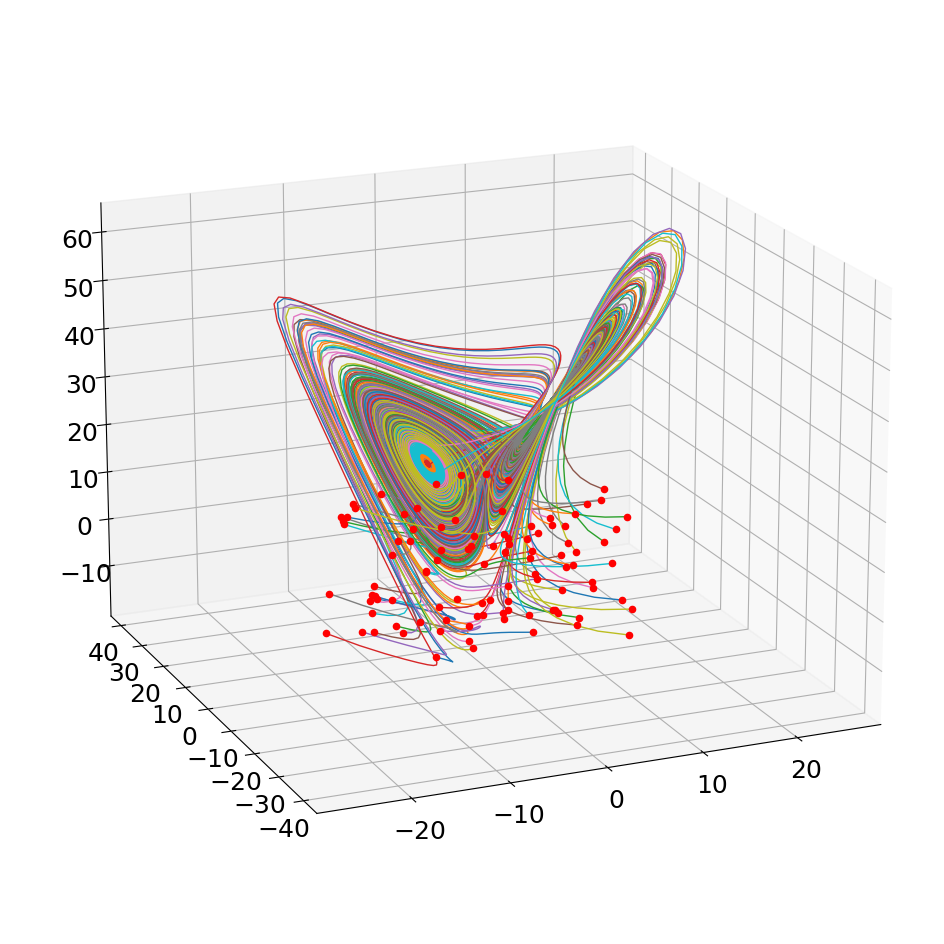

ρ=10, Epoch 1, loss=303.5563
ρ=10, Epoch 2, loss=302.9981
ρ=10, Epoch 3, loss=301.9395
ρ=10, Epoch 4, loss=300.4342
ρ=10, Epoch 5, loss=298.5332
ρ=10, Epoch 6, loss=296.2840
ρ=10, Epoch 7, loss=293.7313
ρ=10, Epoch 8, loss=290.9164
ρ=10, Epoch 9, loss=287.8766
ρ=10, Epoch 10, loss=284.6453
ρ=10, Epoch 11, loss=281.2521
ρ=10, Epoch 12, loss=277.7226
ρ=10, Epoch 13, loss=274.0795
ρ=10, Epoch 14, loss=270.3421
ρ=10, Epoch 15, loss=266.5274
ρ=10, Epoch 16, loss=262.6496
ρ=10, Epoch 17, loss=258.7216
ρ=10, Epoch 18, loss=254.7551
ρ=10, Epoch 19, loss=250.7624
ρ=10, Epoch 20, loss=246.7574
ρ=10, Epoch 21, loss=242.7567
ρ=10, Epoch 22, loss=238.7792
ρ=10, Epoch 23, loss=234.8451
ρ=10, Epoch 24, loss=230.9729
ρ=10, Epoch 25, loss=227.1762
ρ=10, Epoch 26, loss=223.4608
ρ=10, Epoch 27, loss=219.8242
ρ=10, Epoch 28, loss=216.2564
ρ=10, Epoch 29, loss=212.7426
ρ=10, Epoch 30, loss=209.2669
ρ=28, Epoch 1, loss=280.1624
ρ=28, Epoch 2, loss=279.6705
ρ=28, Epoch 3, loss=278.7384
ρ=28, Epoch 4, loss=27

In [8]:
#Github username: chetiyer


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
sequence_length = len(t) - 1  # Define the sequence length
beta = 8/3
sigma = 10
rho = 28


nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

def advance_lorenz(x_y_z, t0, delta_t, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    dx_dt = lorenz_deriv(x_y_z, t0, sigma, beta, rho)
    x_new = x + dx_dt[0] * delta_t
    y_new = y + dx_dt[1] * delta_t
    z_new = z + dx_dt[2] * delta_t
    return [x_new, y_new, z_new]

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define activation functions
def logsig(x):
    return 1 / (1 + torch.exp(-x))

def radbas(x):
    return torch.exp(-torch.pow(x, 2))

def purelin(x):
    return x

# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(in_features=3, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=3)
        
        # Initialize the weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
        # Initialize the biases
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

        
    def forward(self, x):
        x = logsig(self.fc1(x))
        x = radbas(self.fc2(x))
        x = purelin(self.fc3(x))
        return x

def generate_data(p):
    # Set the desired ρ value
    rho = p

    # Generate the initial conditions
    np.random.seed(123)
    x0 = -15 + 30 * np.random.random((100, 3))

    # Generate the time vector
    dt = 0.01
    T = 8
    t = np.arange(0, T + dt, dt)

    # Generate the input and output arrays
    nn_input = np.zeros((100 * (len(t) - 1), 3))
    nn_output = np.zeros_like(nn_input)

    # Generate the Lorenz system trajectories
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                      for x0_j in x0])

    for j in range(100):
        nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
        nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]

    # Convert numpy arrays to PyTorch tensors
    nn_input = torch.from_numpy(nn_input).float()
    nn_output = torch.from_numpy(nn_output).float()

    return nn_input, nn_output


p_values = [10, 28, 40]
epochs = 30

for p in p_values:
    # Generate the training data for the current ρ value
    nn_input, nn_output = generate_data(p)

    # Create model instance
    model = MyModel()

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Train the model
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(nn_input)
        loss = criterion(outputs, nn_output)
        loss.backward()

        # Apply gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

        optimizer.step()
        print(f"ρ={p}, Epoch {epoch + 1}, loss={loss.item():.4f}")

# Evaluate the model on future state
criterion = nn.MSELoss(reduction='mean')  # Change the reduction mode to 'mean'

for p_future in [17, 35]:
    nn_input_future, nn_output_future = generate_data(p_future)
    predicted_output = model(nn_input_future)

    # Calculate the loss
    loss_future = criterion(predicted_output, nn_output_future)
    print(f"Loss for future state (ρ = {p_future}): {loss_future.item():.4f}")

# input_size =  3 ####
# hidden_size = 10 ####
# output_size = 3 ####
# reservoir_size = 3

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Feed-forward neural network model
class FeedForwardModel(nn.Module):
    def __init__(self):
        super(FeedForwardModel, self).__init__()
        self.fc1 = nn.Linear(in_features=3, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=3)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=10, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=10, out_features=3)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

# RNN model
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=3, hidden_size=10, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=10, out_features=3)

    def forward(self, x):
        _, h_n = self.rnn(x)
        x = self.fc(h_n[-1])
        return x


# Echo State Network (ESN) model
# class ESNModel(nn.Module):
#     def __init__(self):
#         super(ESNModel, self).__init__()
#         self.fc_in = nn.Linear(in_features=3, out_features=10, bias=False)
#         self.fc_reservoir = nn.Linear(in_features=10, out_features=10, bias=False)
#         self.fc_out = nn.Linear(in_features=10, out_features=3, bias=False)

#     def forward(self, x):
#         x = self.fc_in(x)
#         x_t = torch.zeros(x.size(0), 10).to(x.device)
#         for t in range(x.size(1)):
#             if t == 0:
#                 x_t = torch.tanh(x[:, t, :])
#             else:
#                 x_t = torch.tanh(x[:, t, :] + self.fc_reservoir(x_t))
#         x = self.fc_out(x_t)
#         return x


p_values = [10, 28, 40]
epochs = 30

model_types = {
    "Feed-Forward": FeedForwardModel(),
    "LSTM": LSTMModel(),
    "RNN": RNNModel(),
}

for model_name, model in model_types.items():
    print(f"Training {model_name} model")

    for p in p_values:
        # Generate the training data for the current ρ value
        nn_input, nn_output = generate_data(p)

        # Create model instance
        model = model_types[model_name]

        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


    # Train the model
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(nn_input)
        loss = criterion(outputs, nn_output)
        loss.backward()

        # Apply gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        print(f"ρ={p}, Epoch {epoch + 1}, loss={loss.item():.4f}")

# Evaluate the model on future state
criterion = nn.MSELoss(reduction='mean')

for p_future in [17, 35]:
    nn_input_future, nn_output_future = generate_data(p_future)
    predicted_output = model(nn_input_future)

    # Calculate the loss
    loss_future = criterion(predicted_output, nn_output_future)
    print(f"{model_name} - Loss for future state (ρ = {p_future}): {loss_future.item():.4f}")

        
        
        